#### Experiment: 

Evaluate pruning by magnitude weighted by coactivations (more thorough evaluation), compare it to baseline (SET), in GSC. Applied only to linear layers

#### Motivation.

Check if results are consistently above baseline.

#### Conclusion


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import glob
import tabulate
import pprint
import click
import numpy as np
import pandas as pd
from ray.tune.commands import *
from nupic.research.frameworks.dynamic_sparse.common.browser import *

import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("colorblind")

## Load and check data

In [3]:
exps = ['improved_mag_gsc_eval3', 'improved_mag_gsc_eval20']
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

In [4]:
df.head(5)

,Experiment Name,train_acc_max,train_acc_max_epoch,train_acc_min,train_acc_min_epoch,train_acc_median,train_acc_last,val_acc_max,val_acc_max_epoch,val_acc_min,...,momentum,network,on_perc,optim_alg,pruning_early_stop,test_noise,use_kwinners,weight_decay,weight_prune_perc,sparse_linear_only
0,"0_model=DSNNWeightedMag,on_perc=0.0",0.092960,19,0.087052,47,0.089689,0.089542,0.103448,22,0.000000,...,0.0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3,NaN
1,"1_model=DSNNMixedHeb,on_perc=0.0",0.091934,24,0.085880,33,0.089591,0.089542,0.103448,10,0.000000,...,0.0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3,NaN
2,"2_model=SparseModel,on_perc=0.0",0.092325,38,0.085587,99,0.089322,0.085587,0.103448,5,0.000000,...,0.0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3,NaN
3,"3_model=DSNNWeightedMag,on_perc=0.005",0.399522,7,0.156821,0,0.199736,0.196026,0.394592,8,0.145376,...,0.0,GSCHeb,0.005,SGD,2,False,True,0.01,0.3,NaN
4,"4_model=DSNNMixedHeb,on_perc=0.005",0.365931,11,0.181330,0,0.296016,0.296065,0.362461,11,0.087382,...,0.0,GSCHeb,0.005,SGD,2,False,True,0.01,0.3,NaN


In [5]:
# replace hebbian prine
df['hebbian_prune_perc'] = df['hebbian_prune_perc'].replace(np.nan, 0.0, regex=True)
df['weight_prune_perc'] = df['weight_prune_perc'].replace(np.nan, 0.0, regex=True)

In [6]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'epochs',
       'experiment_file_name', 'trial_time', 'mean_epoch_time',
       'batch_size_test', 'batch_size_train', 'data_dir', 'dataset_name',
       'debug_sparse', 'debug_weights', 'device', 'hebbian_grow',
       'hebbian_prune_perc', 'learning_rate', 'lr_gamma', 'lr_milestones',
       'lr_scheduler', 'model', 'momentum', 'network', 'on_perc', 'optim_alg',
       'pruning_early_stop', 'test_noise', 'use_kwinners', 'weight_decay',
       'weight_prune_perc', 'sparse_linear_only'],
      dtype='object')

In [7]:
df.shape

(423, 41)

In [8]:
df.iloc[1]

Experiment Name                          1_model=DSNNMixedHeb,on_perc=0.0
train_acc_max                                                   0.0919344
train_acc_max_epoch                                                    24
train_acc_min                                                   0.0858803
train_acc_min_epoch                                                    33
train_acc_median                                                0.0895909
train_acc_last                                                   0.089542
val_acc_max                                                      0.103448
val_acc_max_epoch                                                      10
val_acc_min                                                             0
val_acc_min_epoch                                                       0
val_acc_median                                                  0.0971787
val_acc_last                                                    0.0971787
epochs                                

In [9]:
df.groupby('model')['model'].count()

model
DSNNMixedHeb       141
DSNNWeightedMag    141
SparseModel        141
Name: model, dtype: int64

 ## Analysis

Experiment Details

In [10]:
# Did any  trials failed?
df[df["epochs"]<30]["epochs"].count()

6

In [11]:
# Removing failed or incomplete trials
df_origin = df.copy()
df = df_origin[df_origin["epochs"]>=30]
df.shape

(417, 41)

In [12]:
# which ones failed?
# failed, or still ongoing?
df_origin['failed'] = df_origin["epochs"]<30
df_origin[df_origin['failed']]['epochs']

417    20
418    20
419    21
420     8
421     7
422     6
Name: epochs, dtype: int64

In [13]:
# helper functions
def mean_and_std(s):
    return "{:.3f} ± {:.3f}".format(s.mean(), s.std())

def round_mean(s):
    return "{:.0f}".format(round(s.mean()))

stats = ['min', 'max', 'mean', 'std']

def agg(columns, filter=None, round=3):
    if filter is None:
        return (df.groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)
    else:
        return (df[filter].groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)


##### Does improved weight pruning outperforms regular SET

In [14]:
agg(['model'])

val_acc_max_epoch val_acc_max                      model
                       round_mean         min    max   mean    std count
model                                                                   
DSNNMixedHeb                   43       0.103  0.951  0.817  0.180   139
DSNNWeightedMag                40       0.103  0.952  0.818  0.180   139
SparseModel                    66       0.103  0.948  0.825  0.183   139

In [15]:
agg(['on_perc'])

val_acc_max_epoch val_acc_max                      model
               round_mean         min    max   mean    std count
on_perc                                                         
0.000                  20       0.103  0.106  0.106  0.001    21
0.005                  25       0.218  0.738  0.628  0.136    21
0.010                  27       0.609  0.817  0.762  0.056    21
0.015                  31       0.743  0.845  0.811  0.027    21
0.020                  33       0.772  0.863  0.832  0.028    21
0.025                  39       0.793  0.905  0.842  0.031    21
0.030                  48       0.811  0.915  0.862  0.025    21
0.035                  49       0.840  0.918  0.868  0.018    21
0.040                  60       0.842  0.926  0.879  0.019    21
0.045                  63       0.850  0.934  0.880  0.022    21
0.050                  51       0.864  0.938  0.886  0.020    21
0.055                  55       0.861  0.937  0.885  0.023    21
0.060                  51       0.862  0.935  0.886  0.022    21
0.065                  65       0.866  0.945  0.892  0.023    18
0.070                  62       0.865  0.943  0.894  0.023    18
0.075                  48       0.870  0.949  0.897  0.024    18
0.080                  62       0.875  0.948  0.896  0.023    18
0.085                  64       0.866  0.947  0.902  0.022    18
0.090                  76       0.878  0.951  0.900  0.023    18
0.095                  66       0.879  0.949  0.901  0.023    18
0.100                  71       0.878  0.952  0.901  0.023    18

In [16]:
agg(['on_perc', 'model'])

val_acc_max_epoch val_acc_max                       \
                               round_mean         min    max   mean    std   
on_perc model                                                                
0.000   DSNNMixedHeb                   27       0.103  0.106  0.106  0.001   
        DSNNWeightedMag                16       0.103  0.106  0.106  0.001   
        SparseModel                    16       0.103  0.106  0.106  0.001   
0.005   DSNNMixedHeb                    7       0.362  0.726  0.641  0.126   
        DSNNWeightedMag                 5       0.395  0.721  0.623  0.110   
        SparseModel                    64       0.218  0.738  0.619  0.182   
0.010   DSNNMixedHeb                    7       0.639  0.809  0.745  0.058   
        DSNNWeightedMag                 8       0.723  0.793  0.763  0.028   
        SparseModel                    66       0.609  0.817  0.778  0.075   
0.015   DSNNMixedHeb                    9       0.787  0.845  0.807  0.021   
        DSNNWeightedMag                10       0.743  0.837  0.803  0.030   
        SparseModel                    75       0.761  0.844  0.823  0.028   
0.020   DSNNMixedHeb                    9       0.772  0.852  0.823  0.025   
        DSNNWeightedMag                14       0.777  0.860  0.819  0.029   
        SparseModel                    75       0.819  0.863  0.854  0.016   
0.025   DSNNMixedHeb                   23       0.793  0.873  0.822  0.029   
        DSNNWeightedMag                15       0.808  0.905  0.839  0.032   
        SparseModel                    80       0.841  0.882  0.865  0.013   
0.030   DSNNMixedHeb                   32       0.811  0.890  0.849  0.026   
        DSNNWeightedMag                33       0.831  0.915  0.862  0.028   
        SparseModel                    78       0.858  0.891  0.875  0.013   
0.035   DSNNMixedHeb                   31       0.845  0.894  0.861  0.016   
        DSNNWeightedMag                47       0.840  0.918  0.866  0.026   
        SparseModel                    69       0.871  0.883  0.877  0.005   
0.040   DSNNMixedHeb                   63       0.842  0.916  0.872  0.024   
        DSNNWeightedMag                49       0.865  0.926  0.882  0.022   
        SparseModel                    69       0.866  0.895  0.882  0.010   
0.045   DSNNMixedHeb                   52       0.859  0.930  0.878  0.024   
        DSNNWeightedMag                72       0.850  0.934  0.877  0.028   
        SparseModel                    64       0.866  0.910  0.886  0.016   
...                                   ...         ...    ...    ...    ...   
0.055   DSNNMixedHeb                   71       0.861  0.937  0.880  0.026   
        DSNNWeightedMag                28       0.861  0.936  0.889  0.026   
        SparseModel                    67       0.863  0.928  0.887  0.022   
0.060   DSNNMixedHeb                   62       0.862  0.935  0.884  0.025   
        DSNNWeightedMag                38       0.863  0.935  0.881  0.025   
        SparseModel                    55       0.877  0.934  0.892  0.019   
0.065   DSNNMixedHeb                   64       0.884  0.945  0.898  0.024   
        DSNNWeightedMag                58       0.866  0.943  0.886  0.029   
        SparseModel                    74       0.880  0.929  0.892  0.019   
0.070   DSNNMixedHeb                   64       0.871  0.936  0.897  0.023   
        DSNNWeightedMag                64       0.874  0.943  0.890  0.026   
        SparseModel                    60       0.865  0.935  0.894  0.024   
0.075   DSNNMixedHeb                   47       0.885  0.949  0.901  0.024   
        DSNNWeightedMag                49       0.870  0.948  0.893  0.028   
        SparseModel                    47       0.879  0.944  0.897  0.024   
0.080   DSNNMixedHeb                   60       0.885  0.944  0.900  0.022   
        DSNNWeightedMag                53       0.878  0.948  0.893  0.027   
        SparseModel                    72     

In [17]:
# translate model names
rcParams['figure.figsize'] = 16, 8
d = {
    'DSNNWeightedMag': 'WeightedMagnitude',
    'DSNNMixedHeb': 'SET',
    'SparseModel': 'Static',        
}
df_plot = df.copy()
df_plot['model'] = df_plot['model'].apply(lambda x: d[x])

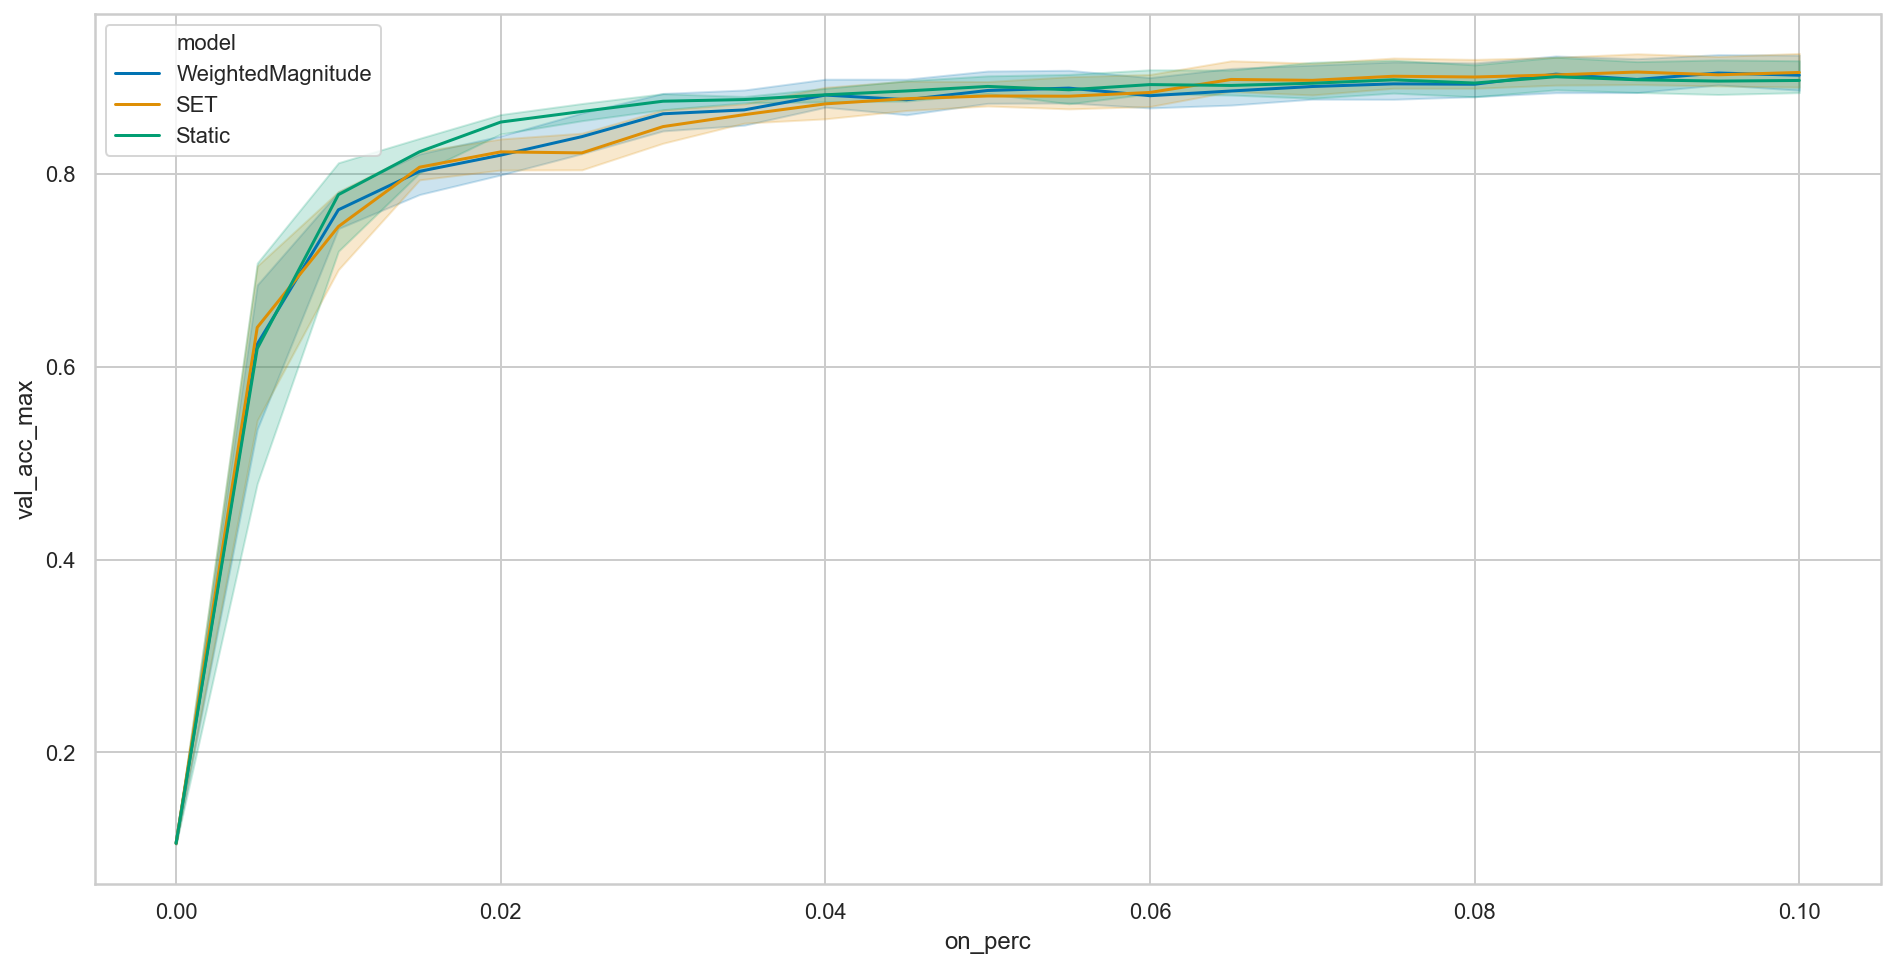

In [18]:
# sns.scatterplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')

(0.8, 0.98)

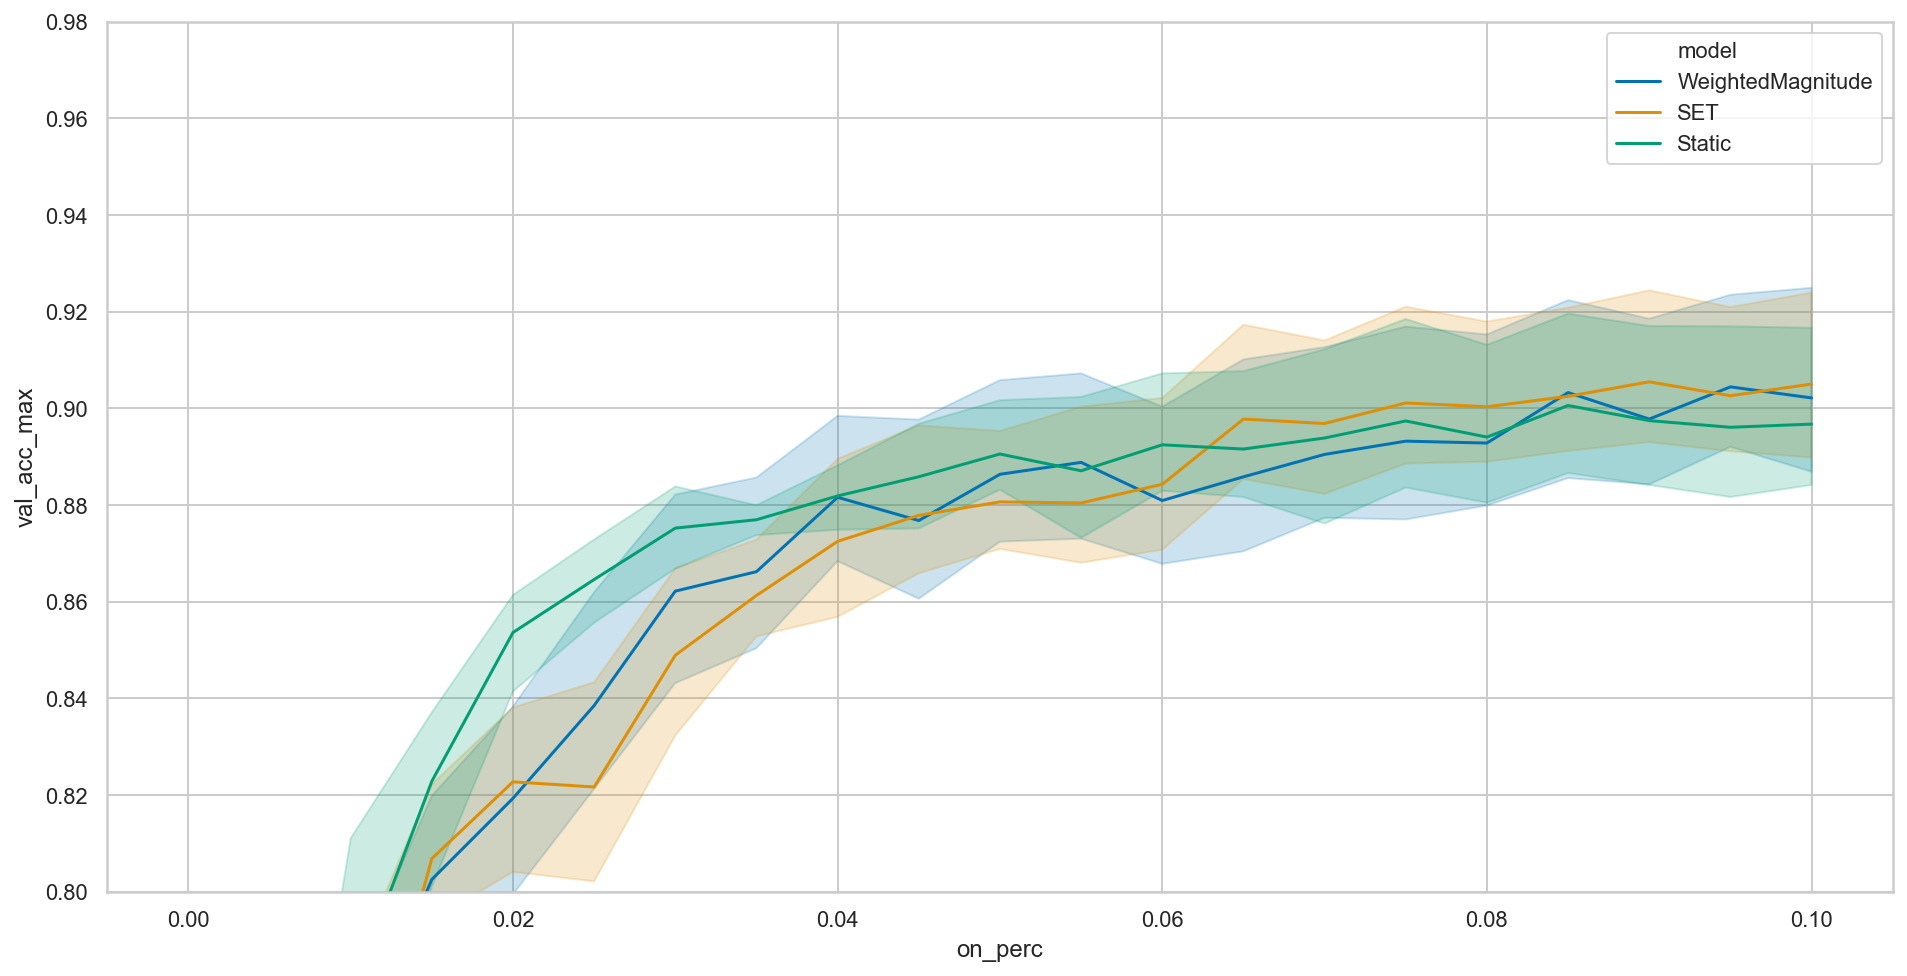

In [19]:
# sns.scatterplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
plt.ylim(0.8,0.98)

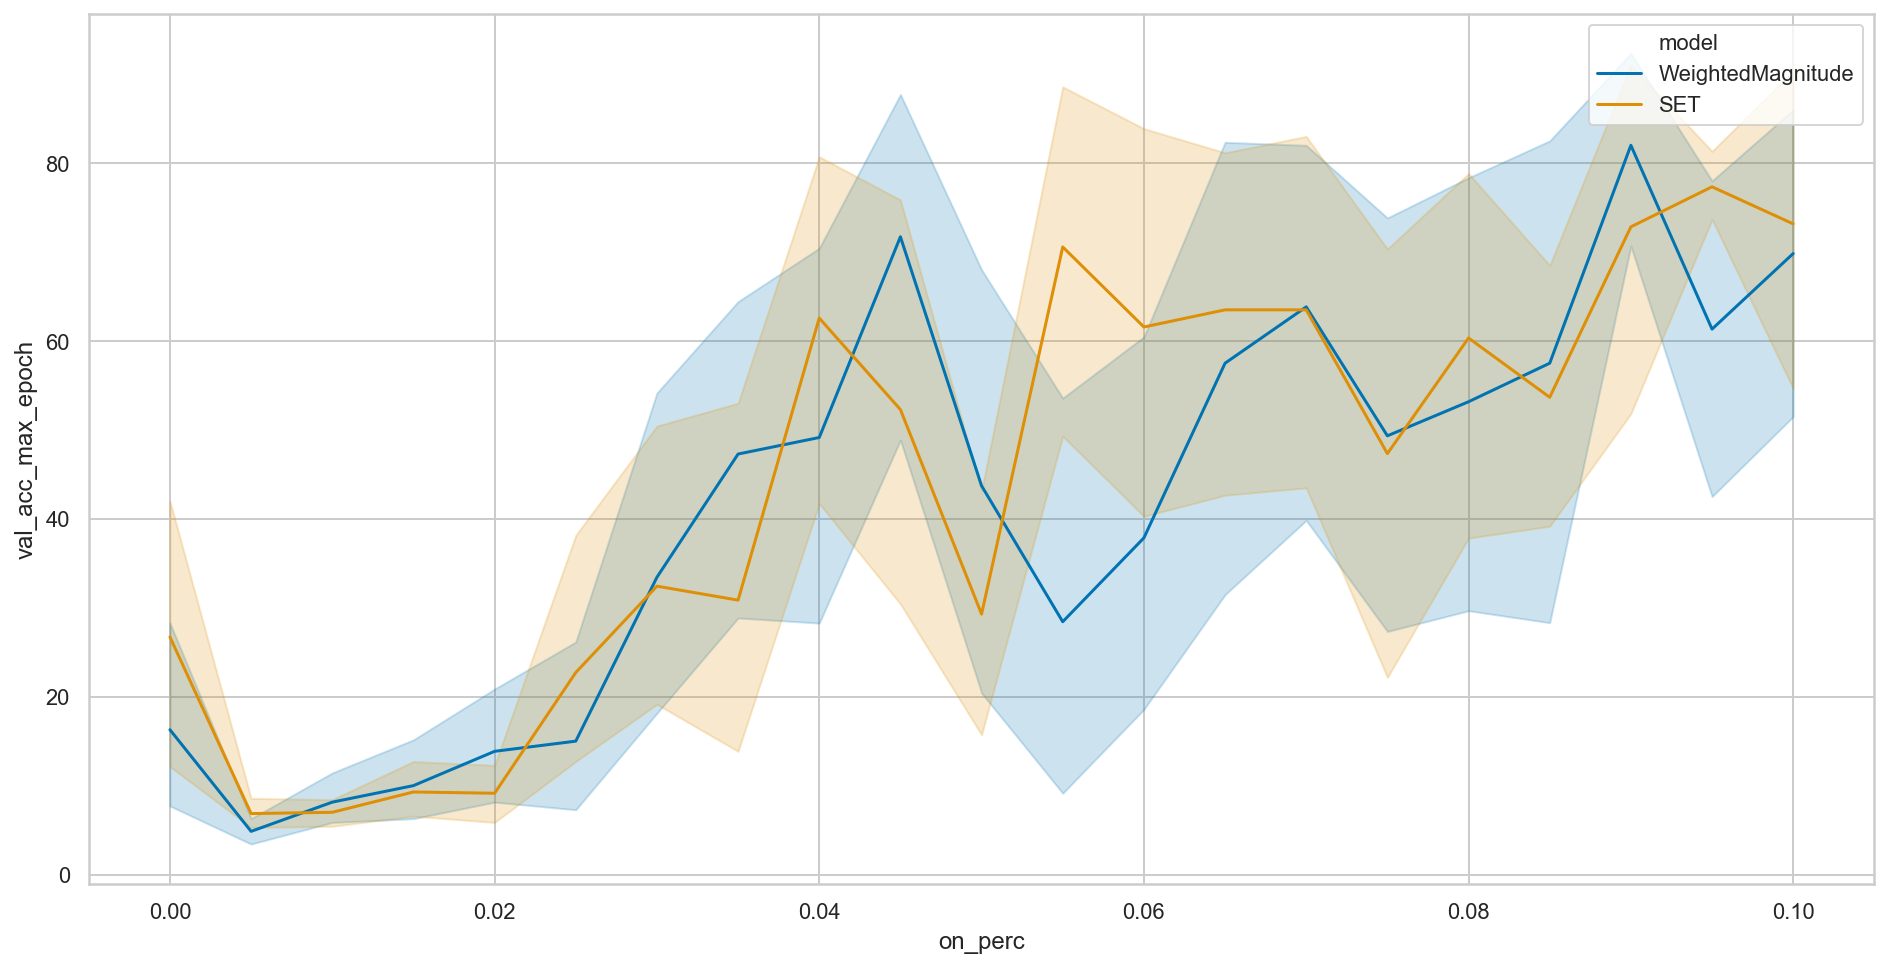

In [20]:
rcParams['figure.figsize'] = 16, 8
filter = df_plot['model'] != 'Static'
sns.lineplot(data=df_plot[filter], x='on_perc', y='val_acc_max_epoch', hue='model')

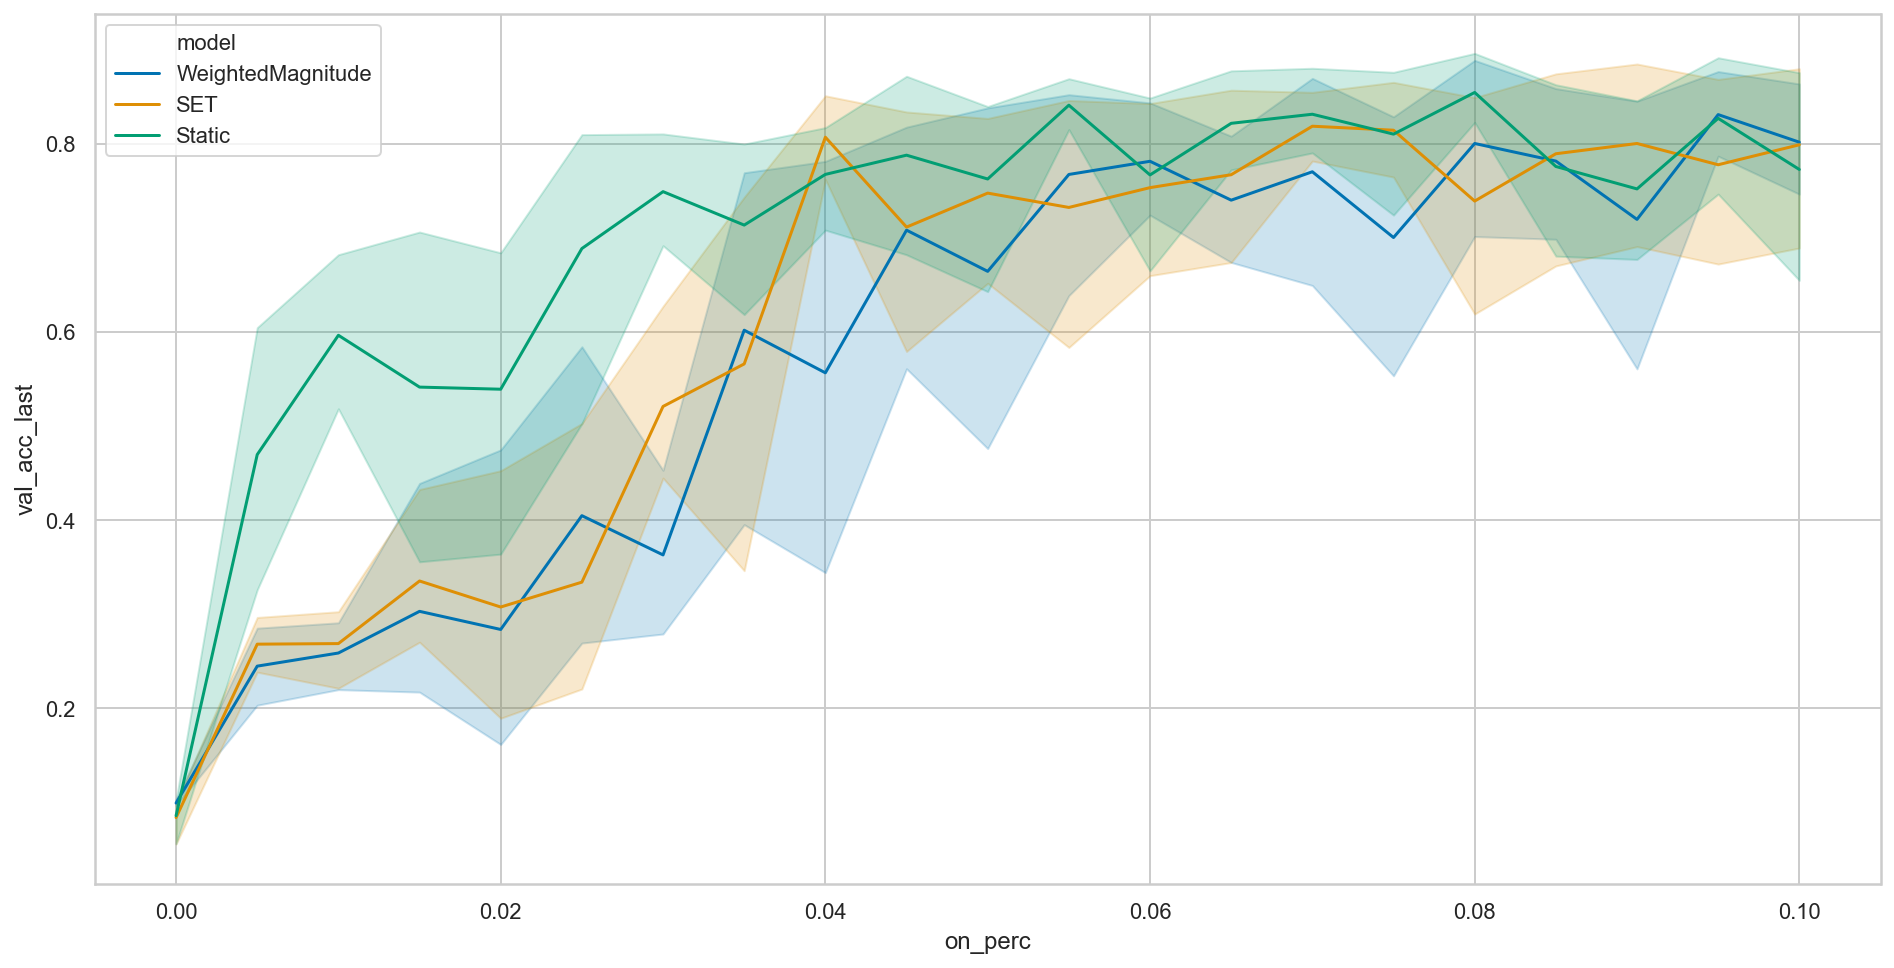

In [21]:
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_last', hue='model')